# Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

# Load and Prepare Data

In [2]:
df = pd.read_csv("iris_csv.csv")
df = df.rename(columns={"class": "label"})

In [3]:
df.head()

,sepallength,sepalwidth,petallength,petalwidth,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Train-Test-Split

In [4]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indicies = df.index.tolist()
    test_indicies = random.sample(population=indicies, k=test_size)

    test_df = df.loc[test_indicies]
    train_df = df.drop(test_indicies)
    
    return train_df, test_df

In [5]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=20)

In [6]:
test_df.head()

,sepallength,sepalwidth,petallength,petalwidth,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


In [7]:
test_df.head()

,sepallength,sepalwidth,petallength,petalwidth,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


# Helper Functions

In [8]:
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

# Pure data

In [9]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

# Classify

In [10]:
def classify_data(data):
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [11]:
classify_data(train_df[train_df.petalwidth > 1.2].values)

'Iris-virginica'

### Potential Splits?

In [12]:
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[column_index].append(potential_split)
                
    return potential_splits

In [13]:
potential_splits = get_potential_splits(train_df.values)

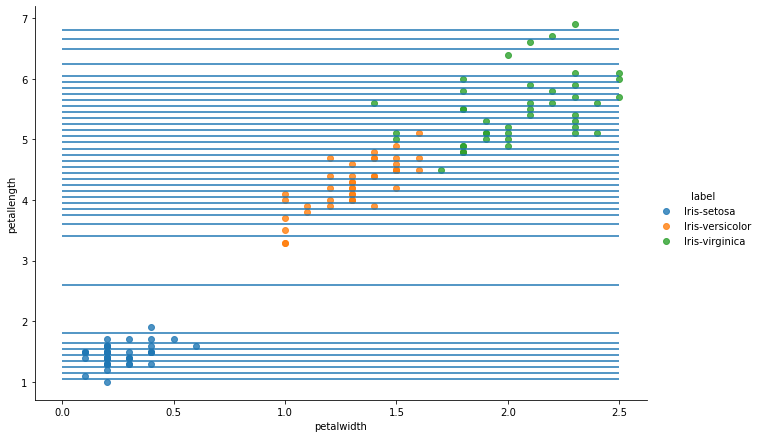

In [14]:
sns.lmplot(data=train_df, x="petalwidth", y="petallength", hue="label",
          fit_reg=False, height=6, aspect=1.5)

#plt.vlines(x=potential_splits[3], ymin=1, ymax=7)
plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5)

### Split Data

In [15]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above

In [16]:
split_column = 3
split_value = 0.8

In [17]:
data_below, data_above = split_data(data, split_column, split_value)

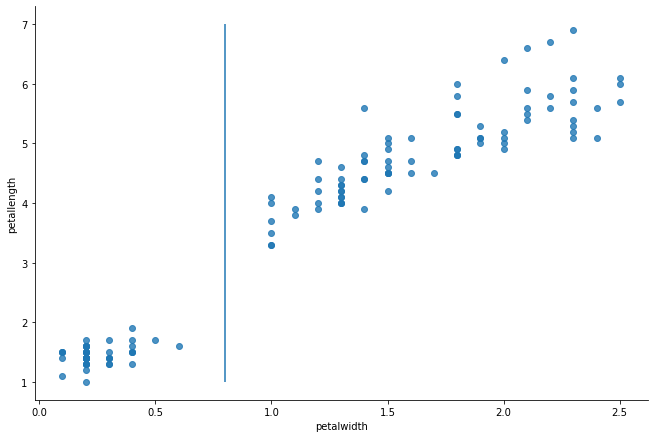

In [18]:
plotting_df = pd.DataFrame(data, columns=df.columns)

sns.lmplot(data=plotting_df, x="petalwidth", y="petallength", fit_reg=False, height=6, aspect=1.5)
plt.vlines(x=split_value, ymin=1, ymax=7)

### Lowest Overall Entropy?

In [19]:
def calculate_entropy(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    
    return entropy

In [20]:
def calculate_overall_entropy(data_below, data_above):
    
    n_data_points = len(data_below) + len(data_above)
    
    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points
    
    overall_entropy = (p_data_below * calculate_entropy(data_below)
                      +p_data_above *calculate_entropy(data_above))
    
    return overall_entropy

In [21]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [22]:
potential_splits = get_potential_splits(data)

In [23]:
determine_best_split(data, potential_splits)

(3, 0.8)

# Decision Tree Algorithm

In [24]:
sub_tree = {"question": ["yes_answer", 
                         "no_answer"]}

In [25]:
example_tree = {"petalwidth <= 0.8": ["Iris-setosa", 
                                      {"petalwidth <= 1.65": [{"petallength <= 4.9": ["Iris-versicolor", 
                                                                                      "Iris-virginica"]}, 
                                                               "Iris-virginica"]}]}

In [26]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base cases).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [27]:
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'petalwidth <= 0.8': ['Iris-setosa',
                       {'petalwidth <= 1.65': [{'petallength <= 4.95': ['Iris-versicolor',
                                                                        'Iris-virginica']},
                                               'Iris-virginica']}]}


# Classification

In [28]:
sub_tree

{'question': ['yes_answer', 'no_answer']}

In [29]:
example = test_df.iloc[0]
example

sepallength                5.1
sepalwidth                 2.5
petallength                  3
petalwidth                 1.1
label          Iris-versicolor
Name: 98, dtype: object

In [30]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [31]:
classify_example(example, tree)

'Iris-versicolor'

# Calculate Accuracy

In [32]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [33]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.95

In [34]:
test_df

,sepallength,sepalwidth,petallength,petalwidth,label,classification,classification_correct
98,5.1,2.5,3.0,1.1,Iris-versicolor,Iris-versicolor,True
107,7.3,2.9,6.3,1.8,Iris-virginica,Iris-virginica,True
10,5.4,3.7,1.5,0.2,Iris-setosa,Iris-setosa,True
66,5.6,3.0,4.5,1.5,Iris-versicolor,Iris-versicolor,True
130,7.4,2.8,6.1,1.9,Iris-virginica,Iris-virginica,True
124,6.7,3.3,5.7,2.1,Iris-virginica,Iris-virginica,True
103,6.3,2.9,5.6,1.8,Iris-virginica,Iris-virginica,True
77,6.7,3.0,5.0,1.7,Iris-versicolor,Iris-virginica,False
122,7.7,2.8,6.7,2.0,Iris-virginica,Iris-virginica,True
91,6.1,3.0,4.6,1.4,Iris-versicolor,Iris-versicolor,True
